In [15]:
# import libraries
import os, sys, glob

import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame

import tables

# pip install simweights <--- run this once to install the package
# then replace <username> with your username and <version> with your Python version
sys.path.append('/home/tfutrell/.local/lib/python3.12/site-packages')
import simweights

In [3]:
# Load in the SIBYLL2.1 particle sims
proton_filelist = glob.glob('/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/p/12360_v1s/h5files/*.h5')
helium_filelist = glob.glob('/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/He/12630_v1s/h5files/*.h5')
oxygen_filelist = glob.glob('/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/O/12631_v1s/h5files/*.h5')
iron_filelist = glob.glob('/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/Fe/12362_v1s/h5files/*.h5')

bigfilelist = proton_filelist + helium_filelist + oxygen_filelist + iron_filelist

In [4]:
# Set the weighter for the data
weighter = None

for filename in bigfilelist:
    file_obj = tables.open_file(filename, 'r')
    
    if weighter is None:
        weighter = simweights.IceTopWeighter(file_obj)
    else:
        weighter += simweights.IceTopWeighter(file_obj)

In [5]:
# probably want to save these to pickle files
primary_energy = weighter.get_column('MCPrimary', 'energy')
particle_type = weighter.get_column('MCPrimary', 'type')

#figure how to get this to work with IceTopHLCSeedRTPulses_SnowUnAttenuated, string
hits = weighter.get_column('IceTopHLCSeedRTPulses_SnowUnAttenuated_info', 'nstrings')

# (p, He, N, Al, Fe) version of this model.
fluxH = simweights.GaisserH4a_IT()

# Get the weights by passing the flux to the weighter
weights = weighter.get_weights(fluxH)

In [6]:
# Dictionary for weight data (practice in using dictionaries)
CUTS = {
    'proton': particle_type==2.21200000e+03,
    'helium' : particle_type==1.00002004e+09,
    'oxygen': particle_type==1.00008016e+09,
    'iron': particle_type==1.00026056e+09,
    'true': np.tile(True, len(primary_energy))
}
Z = {
    'true': 0,
    'proton': 1,
    'helium': 2,
    'oxygen': 8,
    'iron': 26  
}
TIERS = {
    'Tier 1': (3<=hits)*(hits<5),
    'Tier 2': (5<=hits)*(hits<9),
    'Tier 3': (9<=hits)*(hits<16),
    'Tier 4': 16<=hits
}
COLORS = {
    'true' : 'black',
    'proton': 'red',
    'helium': 'orange',
    'oxygen': 'green',
    'iron': 'blue'
}
LABEL = {
    'true' : 'Data',
    'proton': 'P',
    'helium': 'He',
    'oxygen': 'O',
    'iron': 'Fe'
}
WEIGHTS = {
    'true' : {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))},
    'proton': {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))},
    'helium': {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))},
    'oxygen': {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))},
    'iron': {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))}
}
BINS = {
    'true' : {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))},
    'proton': {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))},
    'helium': {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))},
    'oxygen': {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))},
    'iron': {'Tier1': np.empty(len(primary_energy)), 'Tier 2': np.empty(len(primary_energy)), 'Tier 3': np.empty(len(primary_energy)), 'Tier 4': np.empty(len(primary_energy))}
}

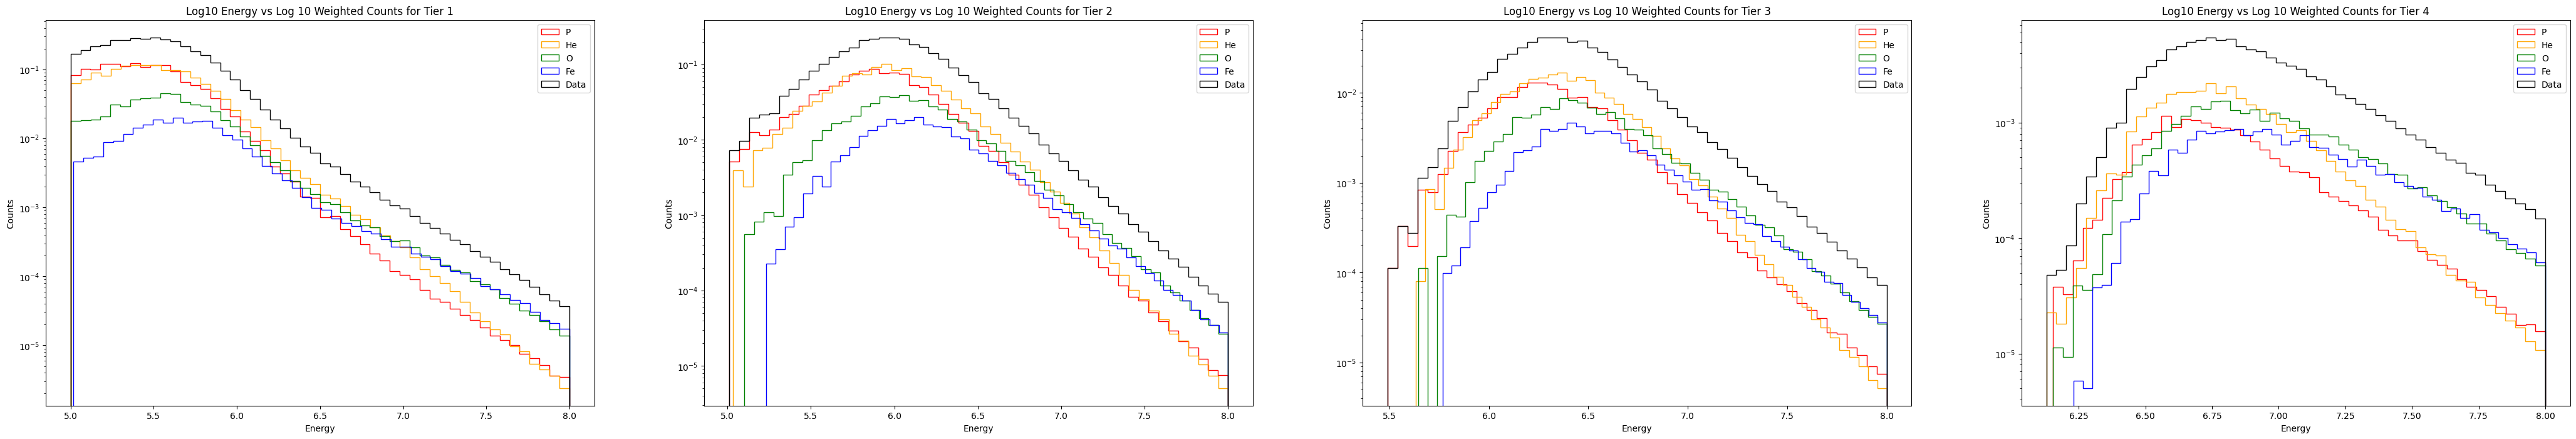

In [10]:
# Graph Log10 Energy vs Log 10 weighted counts

fig, axs = plt.subplots(figsize = (52, 8), ncols=4)

for ax, tier in zip(axs, TIERS):
    for cut in CUTS:
        combined_cuts = CUTS[cut] * TIERS[tier]
        WEIGHTS[cut][tier], BINS[cut][tier], patches1 = ax.hist(np.log10(primary_energy)[combined_cuts], bins=50, weights=weights[combined_cuts], log=True, label = LABEL[cut], histtype='step', color=COLORS[cut])
    
    ax.set_xlabel('Energy')
    ax.set_ylabel('Counts')
    ax.set_title(f'Log10 Energy vs Log 10 Weighted Counts for {tier}')
    ax.legend()

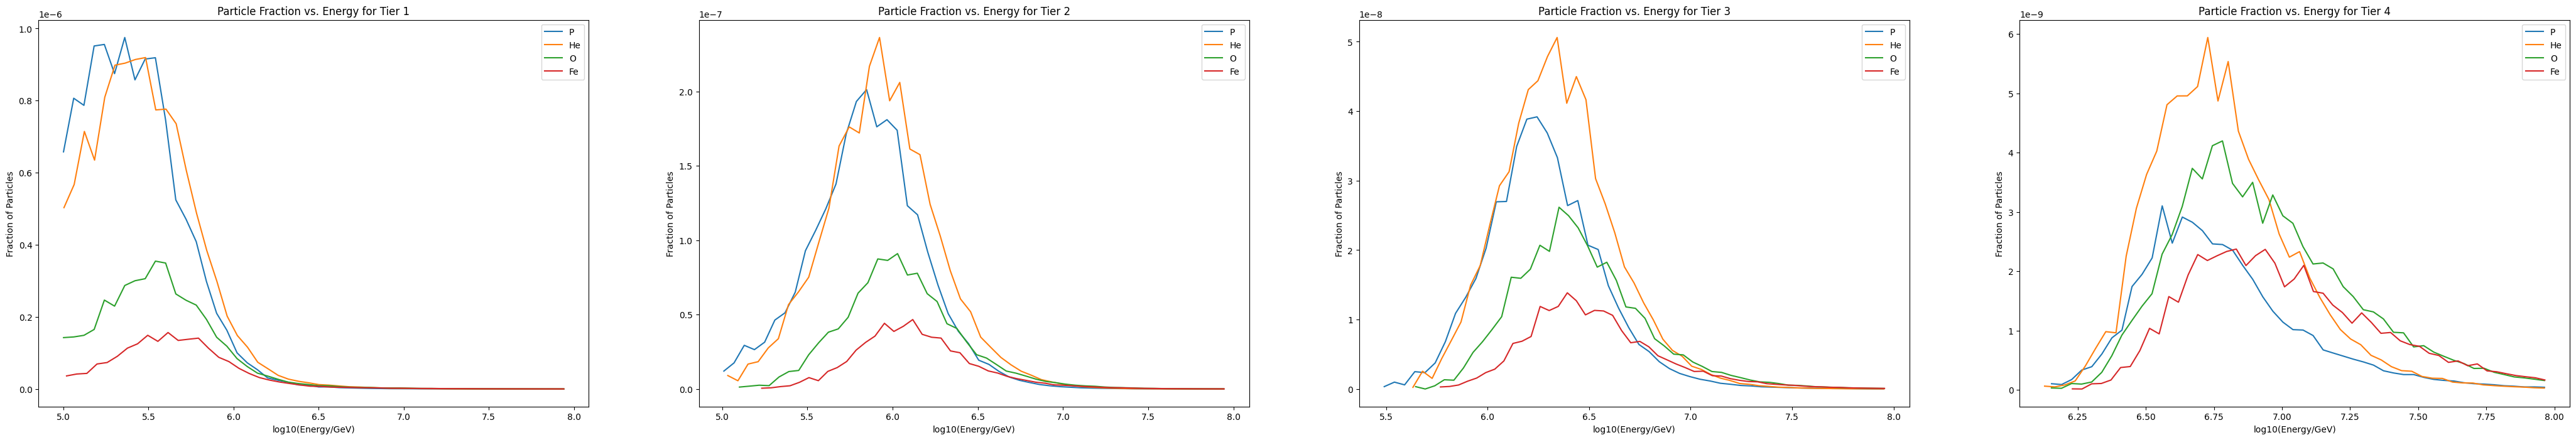

In [11]:
# Particle Fraction vs. Energy
fig, axs = plt.subplots(figsize=(52, 8), ncols=4)

for ax, tier in zip(axs, TIERS):
    for cut in CUTS:
        if not cut=='true':
            ax.plot(BINS[cut][tier][:-1], WEIGHTS[cut][tier]/len(primary_energy[TIERS[tier]]), label=LABEL[cut])

    ax.set_xlabel('log10(Energy/GeV)')
    ax.set_ylabel('Fraction of Particles')
    ax.set_title(f'Particle Fraction vs. Energy for {tier}')

    ax.legend()

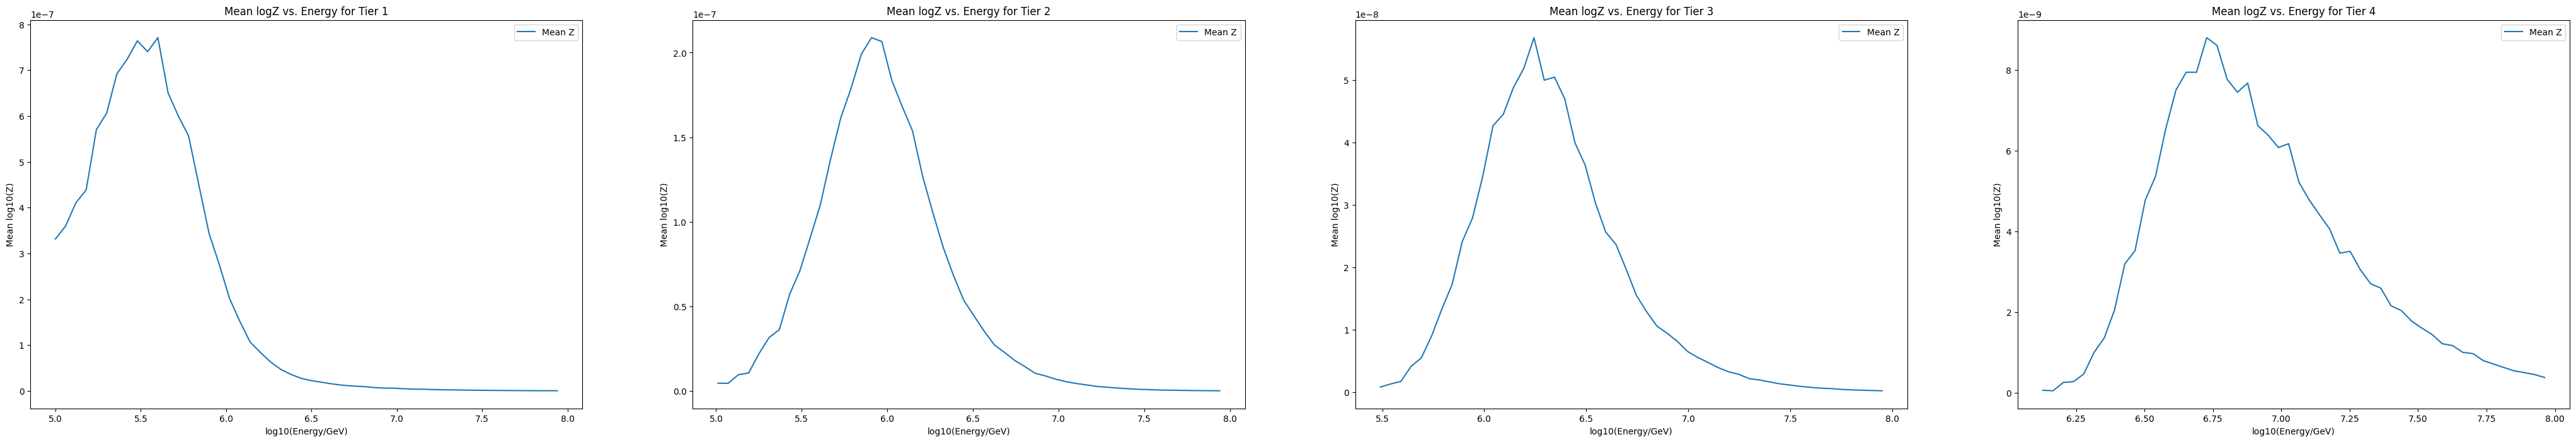

In [12]:
# Mean Atomic Charge

fig, axs = plt.subplots(figsize=(52, 8), ncols=4)

for tier, ax in zip(TIERS, axs):
    totZ = 0
    
    for cut in CUTS:
        if not cut=='true':
            totZ += WEIGHTS[cut][tier] * np.log10(Z[cut])

    meanZ = totZ / len(primary_energy[TIERS[tier]])

    ax.plot(BINS['true'][tier][:-1], meanZ, label = 'Mean Z')

    ax.set_xlabel('log10(Energy/GeV)')
    ax.set_ylabel('Mean log10(Z)')
    ax.set_title(f'Mean logZ vs. Energy for {tier}')

    ax.legend()

In [23]:
# Make a table of the overall percentage of particles
TABLE = {
    'Tier 1': {'proton': None, 'helium': None, 'oxygen': None, 'iron': None},
    'Tier 2': {'proton': None, 'helium': None, 'oxygen': None, 'iron': None},
    'Tier 3': {'proton': None, 'helium': None, 'oxygen': None, 'iron': None},
    'Tier 4': {'proton': None, 'helium': None, 'oxygen': None, 'iron': None}
}
for tier in TIERS:
    for cut in CUTS:
        if not cut=='true':
            combined_cuts = CUTS[cut] * TIERS[tier]
            TABLE[tier][cut] = round(len(primary_energy[combined_cuts])/len(primary_energy[TIERS[tier]]), 3)
print(DataFrame(TABLE))
#for tier in TIERS:
#    print(f"{tier}:")
#    print()
#    for cut in CUTS:
#        if not cut=='true':
#            combined_cuts = CUTS[cut] * TIERS[tier]
#            print(f"[{cut}, {round(len(primary_energy[combined_cuts])/len(primary_energy[TIERS[tier]]), 3)}]")
#            print()

        Tier 1  Tier 2  Tier 3  Tier 4
proton   0.257   0.273   0.266   0.254
helium   0.253   0.261   0.256   0.251
oxygen   0.246   0.243   0.247   0.249
iron     0.244   0.223   0.231   0.245


In [11]:
fluxG = simweights.GlobalSplineFit_IT()

print(fluxG.pdgids)
print(fluxG.groups)